In [ ]:
# Jean setup:
import findspark
findspark.init()

#pathBme = "C:\SofiaAirQuality\Bme"
#pathSds = "C:\SofiaAirQuality\Sds"

In [19]:
# Luiz setup
pathBme = "/home/luiz/SofiaAirQuality/OneMonthBme"
pathSds = "/home/luiz/SofiaAirQuality/OneMonthSds"

In [125]:
import numpy as np

from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql import SparkSession, Window
from pyspark.sql.types import StructType, StringType, DoubleType, ArrayType, IntegerType
from pyspark.sql.functions import col, unix_timestamp, expr, avg, udf
import pyspark.sql.functions as f

from pyspark.ml.classification import NaiveBayes, RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GeneralizedLinearRegression, DecisionTreeRegressor

import matplotlib.pyplot as plt


In [126]:
# Configuração
spark = SparkSession \
    .builder \
    .master("local[12]") \
    .appName("tp_final_jean_luiz").getOrCreate()

df1Schema = StructType() \
    .add("_c0", "integer") \
    .add("sensor_id", "integer") \
    .add("location", "integer") \
    .add("lat", "double") \
    .add("long", "double") \
    .add("timestamp", "timestamp") \
    .add("pressure", "double") \
    .add("temperature", "double") \
    .add("humidity", "double") \

df2Schema = StructType() \
    .add("_c0", "integer") \
    .add("sensor_id", "integer") \
    .add("location", "integer") \
    .add("lat", "double") \
    .add("long", "double") \
    .add("timestamp", "timestamp") \
    .add("P1", "double") \
    .add("P2", "double") \

df1 = spark.read.schema(df1Schema).format("csv").load(pathBme, header=True)
df2 = spark.read.schema(df2Schema).format("csv").load(pathSds, header=True)

In [127]:
df1 = df1 \
    .withColumn("df1SensorId", df1.sensor_id) \
    .withColumn("df1Location", df1.location) \
    .withColumn("df1Lat", df1.lat) \
    .withColumn("df1Long", df1.long) \
    .withColumn("df1Timestamp", df1.timestamp) \
    .withColumn("df1Id", df1.sensor_id).limit(150000)

df2 = df2 \
    .withColumn("df2SensorId", df2.sensor_id) \
    .withColumn("df2Location", df2.location) \
    .withColumn("df2Lat", df2.lat) \
    .withColumn("df2Long", df2.long) \
    .withColumn("df2Timestamp", df2.timestamp) \
    .withColumn("df2Id", df2.sensor_id).limit(150000)

In [128]:
print(df1.count())
print(df2.count())

150000
150000


Para analisar os dados no contexto macro, vamos realizar um join entre os dados dos sensores de tipos diferentes.
Após análise exploratória inicial, identificamos que os sensores ficam em pontos compartilhados, de forma que mesmo que sensores dos dois tipos (SDS e BME) compartilham a coluna "location". Dessa forma, podemos fazer um join por location, e também pegar reports próximos na linha do tempo, para manter uma noção de temporalidade na análise dos dados.

In [129]:
joinedWithoutDuplicates = df1.join(
  df2,
  expr("""
    df1Location = df2Location AND
    df1Timestamp <= df2Timestamp + interval 1 minutes AND
    df1Timestamp >= df2Timestamp - interval 1 minutes
    """)
).dropDuplicates(['df1Id', 'df1Timestamp'])

joinedWithoutDuplicates.persist()

print(joinedWithoutDuplicates.count())

22/02/21 19:32:34 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , sensor_id, location, lat, lon, timestamp, pressure, temperature, humidity
 Schema: _c0, sensor_id, location, lat, long, timestamp, pressure, temperature, humidity
Expected: _c0 but found: 
CSV file: file:///home/luiz/SofiaAirQuality/OneMonthBme/2017-07_bme280sof.csv
22/02/21 19:32:34 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , sensor_id, location, lat, lon, timestamp, P1, P2
 Schema: _c0, sensor_id, location, lat, long, timestamp, P1, P2
Expected: _c0 but found: 
CSV file: file:///home/luiz/SofiaAirQuality/OneMonthSds/2017-07_sds011sof.csv


96084


Abaixo, uma amostra do dataframe resultante do join:

In [137]:
columnsOfInterest = ['df1Id', 'df1Timestamp', 'df1Location', 'df2Id', 'df2Timestamp', 'df2Location', 'pressure', 'temperature', 'humidity', 'P1', 'P2']

joinedWithoutDuplicates.filter(joinedWithoutDuplicates.df1Id == 2266) \
    .select(*columnsOfInterest).show(20)

+-----+-------------------+-----------+-----+-------------------+-----------+--------+-----------+--------+-----+----+
|df1Id|       df1Timestamp|df1Location|df2Id|       df2Timestamp|df2Location|pressure|temperature|humidity|   P1|  P2|
+-----+-------------------+-----------+-----+-------------------+-----------+--------+-----------+--------+-----+----+
| 2266|2017-07-01 00:00:07|       1140| 2265|2017-07-01 00:00:06|       1140|95270.27|      23.46|   62.48|25.33|6.57|
| 2266|2017-07-01 00:02:33|       1140| 2265|2017-07-01 00:02:33|       1140|95266.66|      23.37|    63.4| 15.7|6.27|
| 2266|2017-07-01 00:05:00|       1140| 2265|2017-07-01 00:04:59|       1140|95258.14|      23.37|   63.22|18.17| 6.6|
| 2266|2017-07-01 00:07:26|       1140| 2265|2017-07-01 00:07:26|       1140|95267.81|      23.23|   63.07| 15.9|6.83|
| 2266|2017-07-01 00:09:53|       1140| 2265|2017-07-01 00:09:52|       1140|95267.84|      23.25|   63.37|13.67|5.97|
| 2266|2017-07-01 00:12:19|       1140| 2265|201

É interessante observar também que os ids dos sensores que entram no join são consecutivos, e eles reportam dados em tempos muito similares:

In [138]:
joinedWithoutDuplicates \
    .withColumn("timestampDelta", joinedWithoutDuplicates.df2Timestamp.cast("long") - joinedWithoutDuplicates.df1Timestamp.cast("long")) \
    .withColumn("idDifference", joinedWithoutDuplicates.df2Id - joinedWithoutDuplicates.df1Id) \
    .agg(
        avg("timestampDelta"),
        avg("idDifference")
    ).show()

+-------------------+-----------------+
|avg(timestampDelta)|avg(idDifference)|
+-------------------+-----------------+
|-0.6837142500312227|             -1.0|
+-------------------+-----------------+



Na primeira questão, vamos expandir a análise exploratória e verificar a correlação dos dados de interesse (temperature, humidity, pressure, P1 e P2) do dataframe resultante do join. Queremos definir uma base para a análise das questões 2 e principalmente 3, podendo definir quais as melhores estratégias para o uso de ML para previsão de alguma dessas features.

/home/luiz/.local/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/tmp/ipykernel_23822/810265125.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+attr)
/tmp/ipykernel_23822/810265125.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+attr)


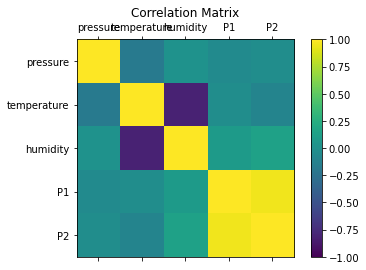

+--------------------+--------------------+--------------------+--------------------+--------------------+
|            pressure|         temperature|            humidity|                  P1|                  P2|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 1.0|-0.17333527149640582|0.016289066010741964|-0.04549370997043...|-0.01811842375469...|
|-0.17333527149640582|                 1.0| -0.8112936285979805|-0.02075341972196368|-0.10023655202389627|
|0.016289066010741964| -0.8112936285979805|                 1.0| 0.09051754868962797|  0.1465245458161027|
|-0.04549370997043...|-0.02075341972196368| 0.09051754868962797|                 1.0|  0.9569931558373822|
|-0.01811842375469...|-0.10023655202389627|  0.1465245458161027|  0.9569931558373822|                 1.0|
+--------------------+--------------------+--------------------+--------------------+--------------------+



In [139]:
# 1. Realizar uma análise da correlação entre os atributos presentes na base de dados 
# (pressão, temperatura, humidade, P1 (PM10) e P2 (PM2,5)).

# Filtrando apenas as colunas desejadas
columns = ['pressure','temperature','humidity', 'P1', 'P2']
df_filtered = joinedWithoutDuplicates.select(*columns)
df_filtered = df_filtered.filter(df_filtered.pressure.isNotNull())
df_filtered = df_filtered.filter(df_filtered.temperature.isNotNull())
df_filtered = df_filtered.filter(df_filtered.humidity.isNotNull())

# Criando coluna de vector
vector_column = "vector_column"
assembler = VectorAssembler(inputCols=df_filtered.columns, outputCol=vector_column)
df_vector = assembler.transform(df_filtered).select(vector_column)

# Obtendo matriz de correlação
matrix = Correlation.corr(df_vector, vector_column).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

# Plotando
def plot_correlation_matrix(correlations,attr,fig_no):
    fig=plt.figure(fig_no)
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()
plot_correlation_matrix(corrmatrix, columns, 234)

spark.createDataFrame(corrmatrix,columns).show() 

Pode-se perceber que temperatura e humidade possuem correlação negativa alta, o que indica que altas temperaturas estão relacionadas com baixos valores de humidade, e vice-versa. Além disso, há uma correlação positiva bastante próxima à 1 entre P1 e P2, o que indica que os valores de qualidade do ar andam juntos, pois muito provavelmente podem ser explicados por um fenômeno subjacente comum (emissão de poluentes).

É bastante interessante analisar os dados de sensores e tentar montar um modelo de previsão, mas dados de sensores defeituosos podem prejudicar o poder de previsão de modelos de ML. Com isso, o objetivo da segunda parte é analisar a presença de outliers no dataset, fazendo análises agrupadas por localização e por tempo de evento.

A ideia principal é obter as coordenadas do "bounding box" da cidade de Sofia, e subdividir os eventos dos sensores da cidade em retângulos discretos (quadrantes), para realizar análises de outliers agrupando por quadrantes.

In [140]:
onlyCoords = joinedWithoutDuplicates.select(["df1Lat", "df1Long"])

minLat = onlyCoords.agg(f.min("df1Lat")).first()[0]
maxLat = onlyCoords.agg(f.max("df1Lat")).first()[0]

minLong = onlyCoords.agg(f.min("df1Long")).first()[0]
maxLong = onlyCoords.agg(f.max("df1Long")).first()[0]

print(f"Min latitude = {minLat}, max latitude = {maxLat}, min longitude = {minLong}, maxLongitude = {maxLong}")

Min latitude = 42.622, max latitude = 42.738, min longitude = 23.254, maxLongitude = 23.419


In [141]:
print(f"Delta latitude: {maxLat - minLat}")
print(f"Delta longitude: {maxLong - minLong}")

latBounds = np.linspace(minLat, maxLat, num=5, endpoint=False)
longBounds = np.linspace(minLong, maxLong, num=5, endpoint=False)

print(latBounds)
print(longBounds)

Delta latitude: 0.11599999999999966
Delta longitude: 0.16499999999999915
[42.622  42.6452 42.6684 42.6916 42.7148]
[23.254 23.287 23.32  23.353 23.386]


In [142]:
def latGrouper(latitude):
    closestLowerLat = float(latBounds[0])
    for lat in latBounds:
        if float(lat) < latitude:
            closestLowerLat = float(lat)
        else:
            break

    return closestLowerLat

def longGrouper(longitude):
    closestLowerLong = float(longBounds[0])
    for lon in longBounds:
        if float(lon) < longitude:
            closestLowerLong = float(lon)
        else:
            break
    return closestLowerLong

Acima foram definidos os limites inferiores de latitude e longitude dos quadrantes, e cada registro será associado à latitude/longitude que for menor e mais próxima à latitude/longitude do evento reportado pelo sensor. Com isso, teremos ao todo 25 possíveis quadrantes. Abaixo, os dados são agrupados ("latBox" e "longBox"), e é calculada uma simples agregação

In [143]:
withBoxData = joinedWithoutDuplicates \
    .withColumn("latBox", udf(latGrouper)(onlyCoords.df1Lat)) \
    .withColumn("longBox", udf(longGrouper)(onlyCoords.df1Long))

groupedByBox = withBoxData.groupBy("latBox", "longBox")

groupedByBox \
    .agg(
        f.count("*").alias("count"),
        f.max("humidity"),
        f.avg("humidity"),
        f.min("humidity")
    ) \
    .orderBy("count") \
    .show()

+-------+------------------+-----+-------------+------------------+-------------+
| latBox|           longBox|count|max(humidity)|     avg(humidity)|min(humidity)|
+-------+------------------+-----+-------------+------------------+-------------+
|42.6684|            23.254| 2352|        100.0|56.162895408163244|        18.91|
|42.6452|            23.386| 2665|         86.7| 46.72035272045033|         5.73|
| 42.622|            23.386| 2670|        81.63|46.980220973782835|        13.73|
|42.7148|23.287000000000003| 2690|        95.63| 55.76173234200752|         8.76|
| 42.622|            23.254| 2703|        95.98|  56.4182981871995|         11.5|
|42.6452|23.287000000000003| 2714|        90.16| 52.50021002210771|        15.39|
|42.7148|            23.254| 2717|        94.79| 56.55189179241801|        16.93|
| 42.622|            23.353| 2719|        93.88| 55.40662008091218|        14.81|
|42.6684|            23.386| 2722|        92.48| 54.91556943423957|        13.07|
| 42.622|23.2870

In [ ]:
withBoxData \
    .select(["df1Timestamp", "df1Lat", "df1Long", "df1SensorId", "df2SensorId", "temperature", "humidity", "pressure", "latBox", "longBox"]) \
    .write.csv("StreamingData/dataWithBoxData.csv")

Abaixo, são definidas três funções de análise de outliers.
Todas elas recebem uma feature como parâmetro, e a quantidade de desvios padrões de distância da média para que uma observação seja considerada um outlier.

A primeira função agrupa a quantidade de outliers considerando tanto a divisão de quadrantes quanto uma janela de tempo de 1 dia, computando média e desvio padrão dentro dessas subdivisões para filtrar a quantidade de observações que ficam fora do range de X desvios padrão da média.

A segunda funciona de forma parecida, desconsiderando as subdivisões de tempo, e a terceira da mesma forma, porém sem fazer qualquer subdivisão do dado.

Com isso, podemos ter agrupamentos mais gerais e mais específicos de outliers, e podemos analisar todas as features de interesse de forma dinâmica.

In [144]:
cnt_cond = lambda cond: f.sum(f.when(cond, 1).otherwise(0))

def analyzeOutliers(feature, stdevs_to_consider_as_outlier):
    windowSpec = Window.partitionBy("latBox", "longBox", f.window("df1Timestamp", "86400 seconds"))
    return withBoxData \
        .withColumn(f"{feature}StandardDeviation", f.stddev_samp(feature).over(
            windowSpec
        )) \
        .withColumn(f"{feature}Average", f.avg(feature).over(
            windowSpec
        )) \
        .withColumn("lowerBound",
            f.expr(f"{feature}Average - ({stdevs_to_consider_as_outlier} * {feature}StandardDeviation)")) \
        .withColumn("upperBound",
            f.expr(f"{feature}Average + ({stdevs_to_consider_as_outlier} * {feature}StandardDeviation)")) \
        .groupBy("latBox", "longBox", f.window("df1Timestamp", "86400 seconds")) \
        .agg(
            f.max(feature),
            f.min(feature),
            f.avg(feature),
            f.count("*").alias("totalCount"),
            cnt_cond((f.col(feature) < f.col('lowerBound')) | (f.col(feature) > f.col('upperBound'))).alias('outlierCount'),
            f.stddev_samp(feature)
        ) \
        .orderBy(f.expr("outlierCount").desc()) \
        .select(["latBox", "longBox", "window.start", "window.end", "totalCount", "outlierCount"])

def analyzeOutliersNoTime(feature, stdevs_to_consider_as_outlier):
    windowSpecNoTime = Window.partitionBy("latBox", "longBox")
    return withBoxData \
        .withColumn(f"{feature}StandardDeviation", f.stddev_samp(feature).over(
            windowSpecNoTime
        )) \
        .withColumn(f"{feature}Average", f.avg(feature).over(
            windowSpecNoTime
        )) \
        .withColumn("lowerBound",
            f.expr(f"{feature}Average - ({stdevs_to_consider_as_outlier} * {feature}StandardDeviation)")) \
        .withColumn("upperBound",
            f.expr(f"{feature}Average + ({stdevs_to_consider_as_outlier} * {feature}StandardDeviation)")) \
        .groupBy("latBox", "longBox") \
        .agg(
            f.max(feature),
            f.min(feature),
            f.avg(feature),
            f.count("*").alias("totalCount"),
            cnt_cond((f.col(feature) < f.col('lowerBound')) | (f.col(feature) > f.col('upperBound'))).alias('outlierCount'),
            f.stddev_samp(feature)
        ) \
        .orderBy(f.expr("outlierCount").desc()) \
        .select(["latBox", "longBox", "totalCount", "outlierCount"])

def analyzeOutliersNoGrouping(feature, stdevs_to_consider_as_outlier):
    average = withBoxData \
        .groupBy().agg(f.avg(feature)) \
        .take(1)[0][0]
    stdev = withBoxData \
        .groupBy().agg(f.stddev_samp(feature)) \
        .take(1)[0][0]
    
    return withBoxData \
        .withColumn(f"{feature}Average", f.lit(average)) \
        .withColumn(f"{feature}StandardDeviation", f.lit(stdev)) \
        .withColumn("lowerBound",
            f.expr(f"{feature}Average - ({stdevs_to_consider_as_outlier} * {feature}StandardDeviation)")) \
        .withColumn("upperBound",
            f.expr(f"{feature}Average + ({stdevs_to_consider_as_outlier} * {feature}StandardDeviation)")) \
        .groupBy() \
            .agg(
                f.max(feature),
                f.min(feature),
                f.avg(feature),
                f.count("*").alias("totalCount"),
                cnt_cond((f.col(feature) < f.col('lowerBound')) | (f.col(feature) > f.col('upperBound'))).alias('outlierCount'),
                f.stddev_samp(feature)
            ) \
            .orderBy(f.expr("outlierCount").desc()) \
            .select(["totalCount", "outlierCount"])

Inicialmente, vamos analisar a temperatura, sob a ótica das três funções:

In [145]:
analyzeOutliersNoGrouping('temperature', stdevs_to_consider_as_outlier=3).show()

+----------+------------+
|totalCount|outlierCount|
+----------+------------+
|     96084|         301|
+----------+------------+



Quando a análise é feita sem agrupamento, temos uma proporção bastante baixa de outliers dentro de todas as observações registradas no dataset.

In [146]:
analyzeOutliersNoTime('temperature', stdevs_to_consider_as_outlier=3).show()

+-------+------------------+----------+------------+
| latBox|           longBox|totalCount|outlierCount|
+-------+------------------+----------+------------+
|42.6916|             23.32|     10688|         114|
| 42.622|23.287000000000003|      2725|          24|
|42.6916|            23.353|     10487|          21|
|42.6684|             23.32|      8847|          13|
|42.6452|            23.254|      5444|           5|
|42.6452|            23.353|      2812|           2|
| 42.622|            23.254|      2703|           1|
|42.6452|             23.32|      5957|           1|
| 42.622|            23.353|      2719|           0|
| 42.622|            23.386|      2670|           0|
|42.6452|            23.386|      2665|           0|
|42.6684|            23.386|      2722|           0|
|42.6452|23.287000000000003|      2714|           0|
|42.6684|            23.254|      2352|           0|
|42.6684|23.287000000000003|     13150|           0|
|42.6916|23.287000000000003|      2735|       

Ao realizar a análise levando em consideração os quadrantes, temos um perfil diferente de quantidade de outliers,
que começam a se agrupar em determinados quadrantes, o que pode significar que alguns sensores específicos estão com problemas (ou que algum evento no mundo real está aumentando/abaixando muito a temperatura reportada por alguns sensores).

In [147]:
analyzeOutliers('temperature', stdevs_to_consider_as_outlier=3).show()

+-------+------------------+-------------------+-------------------+----------+------------+
| latBox|           longBox|              start|                end|totalCount|outlierCount|
+-------+------------------+-------------------+-------------------+----------+------------+
|42.6916|             23.32|2017-07-01 21:00:00|2017-07-02 21:00:00|      2348|          82|
|42.6916|             23.32|2017-07-04 21:00:00|2017-07-05 21:00:00|      1772|          51|
|42.6916|             23.32|2017-06-30 21:00:00|2017-07-01 21:00:00|      1881|          33|
|42.6916|             23.32|2017-07-03 21:00:00|2017-07-04 21:00:00|      2354|          14|
|42.6684|             23.32|2017-07-01 21:00:00|2017-07-02 21:00:00|      1940|          14|
| 42.622|23.287000000000003|2017-07-03 21:00:00|2017-07-04 21:00:00|       590|          11|
| 42.622|23.287000000000003|2017-07-01 21:00:00|2017-07-02 21:00:00|       588|           7|
|42.6684|            23.353|2017-07-04 21:00:00|2017-07-05 21:00:00|  

Ao aumentar a granularidade da análise, novamente temos um perfil distinto, que aponta qual quadrante e em qual dia mais eventos outliers aconteceram. Podemo determinar qual sensor reportou valores extremais:

In [151]:
def getOutlierRows(feature, latBox, longBox, start, end, stdevs_to_consider_as_outlier):
    dates = (start, end)
    average = withBoxData \
        .groupBy().agg(f.avg(feature)) \
        .take(1)[0][0]
    stdev = withBoxData \
        .groupBy().agg(f.stddev_samp(feature)) \
        .take(1)[0][0]
    return withBoxData \
        .withColumn(f"{feature}Average", f.lit(average)) \
        .withColumn(f"{feature}StandardDeviation", f.lit(stdev)) \
        .withColumn("lowerBound",
            f.expr(f"{feature}Average - ({stdevs_to_consider_as_outlier} * {feature}StandardDeviation)")) \
        .withColumn("upperBound",
            f.expr(f"{feature}Average + ({stdevs_to_consider_as_outlier} * {feature}StandardDeviation)")) \
        .filter((f.col(feature) < f.col('lowerBound')) | (f.col(feature) > f.col('upperBound'))) \
        .filter(f.col("latBox") == latBox) \
        .filter(f.col("longBox") == longBox) \
        .filter(f.col("df2Timestamp").between(*dates))

def outlierRows(feature, stdevs_to_consider_as_outlier, latBox, longBox, start, end):
    dates = (start, end)
    windowSpec = Window.partitionBy("latBox", "longBox", f.window("df1Timestamp", "86400 seconds"))
    return withBoxData \
        .withColumn(f"{feature}StandardDeviation", f.stddev_samp(feature).over(
            windowSpec
        )) \
        .withColumn(f"{feature}Average", f.avg(feature).over(
            windowSpec
        )) \
        .withColumn("lowerBound",
            f.expr(f"{feature}Average - ({stdevs_to_consider_as_outlier} * {feature}StandardDeviation)")) \
        .withColumn("upperBound",
            f.expr(f"{feature}Average + ({stdevs_to_consider_as_outlier} * {feature}StandardDeviation)")) \
        .filter((f.col(feature) < f.col('lowerBound')) | (f.col(feature) > f.col('upperBound'))) \
        .filter(f.col("latBox") == latBox) \
        .filter(f.col("longBox") == longBox) \
        .filter(f.col("df1Timestamp").between(*dates))

In [166]:
outlierRows(feature='temperature',
               latBox=42.6916,
               longBox=23.32,
               start="2017-07-01 21:00:00",
               end="2017-07-02 21:00:00",
               stdevs_to_consider_as_outlier=3) \
    .groupBy("df1SensorId") \
    .agg(f.count("*")) \
    .show()

outlierRows(feature='temperature',
               latBox=42.6916,
               longBox=23.32,
               start="2017-07-01 21:00:00",
               end="2017-07-02 21:00:00",
               stdevs_to_consider_as_outlier=3) \
    .select(['df1SensorId', 'df1Timestamp', 'temperature']) \
    .orderBy(f.col('temperature').desc()) \
    .show()

+-----------+--------+
|df1SensorId|count(1)|
+-----------+--------+
|       3500|      65|
|       3738|      17|
+-----------+--------+

+-----------+-------------------+-----------+
|df1SensorId|       df1Timestamp|temperature|
+-----------+-------------------+-----------+
|       3500|2017-07-02 14:08:55|       49.9|
|       3500|2017-07-02 14:11:22|      49.77|
|       3500|2017-07-02 14:23:34|      49.64|
|       3500|2017-07-02 14:13:48|      49.63|
|       3500|2017-07-02 14:16:15|       49.6|
|       3500|2017-07-02 14:04:02|      49.59|
|       3500|2017-07-02 14:06:29|       49.5|
|       3500|2017-07-02 13:51:50|      49.37|
|       3500|2017-07-02 13:54:16|      49.32|
|       3500|2017-07-02 14:01:36|      49.29|
|       3500|2017-07-02 14:26:01|      49.29|
|       3500|2017-07-02 13:49:23|      49.27|
|       3500|2017-07-02 13:20:05|      49.25|
|       3500|2017-07-02 13:44:30|      49.25|
|       3500|2017-07-02 13:22:32|      49.24|
|       3500|2017-07-02 13:46:57|

Podemos perceber que de fato há várias observações com temperaturas altamente elevadas, o que pode configurar um defeito no sensor ou alguma situação real no momento das observações.

Podemos conduzir uma análise parecida para os sensores que reportam partículas P1:

In [167]:
analyzeOutliersNoGrouping('P1', stdevs_to_consider_as_outlier=3).show()

+----------+------------+
|totalCount|outlierCount|
+----------+------------+
|     96084|         372|
+----------+------------+



In [168]:
analyzeOutliersNoTime('P1', stdevs_to_consider_as_outlier=3).show()

+-------+------------------+----------+------------+
| latBox|           longBox|totalCount|outlierCount|
+-------+------------------+----------+------------+
|42.6684|23.287000000000003|     13150|         243|
|42.6916|             23.32|     10688|         178|
|42.6916|            23.353|     10487|          89|
|42.6452|            23.254|      5444|          88|
|42.6684|            23.353|      3984|          85|
|42.6452|             23.32|      5957|          79|
|42.6452|23.287000000000003|      2714|          64|
| 42.622|            23.254|      2703|          63|
|42.6684|            23.254|      2352|          50|
| 42.622|            23.353|      2719|          45|
|42.6452|            23.353|      2812|          45|
|42.7148|            23.254|      2717|          44|
|42.6684|             23.32|      8847|          39|
|42.6684|            23.386|      2722|          39|
|42.6452|            23.386|      2665|          25|
|42.7148|23.287000000000003|      2690|       

In [171]:
analyzeOutliers('P1', stdevs_to_consider_as_outlier=3).show()

+-------+------------------+-------------------+-------------------+----------+------------+
| latBox|           longBox|              start|                end|totalCount|outlierCount|
+-------+------------------+-------------------+-------------------+----------+------------+
|42.6916|             23.32|2017-07-02 21:00:00|2017-07-03 21:00:00|      2333|         113|
|42.6916|             23.32|2017-07-03 21:00:00|2017-07-04 21:00:00|      2354|          90|
|42.6684|23.287000000000003|2017-07-03 21:00:00|2017-07-04 21:00:00|      2681|          47|
|42.6916|             23.32|2017-07-01 21:00:00|2017-07-02 21:00:00|      2348|          44|
|42.6684|             23.32|2017-07-01 21:00:00|2017-07-02 21:00:00|      1940|          30|
|42.6452|             23.32|2017-07-01 21:00:00|2017-07-02 21:00:00|      1166|          29|
|42.6916|            23.353|2017-07-03 21:00:00|2017-07-04 21:00:00|      2335|          27|
|42.6916|            23.353|2017-07-04 21:00:00|2017-07-05 21:00:00|  

Nesse caso, temos um perfil diferente de outliers, o que pode significar que a distribuição das observações de P1 é de cauda mais longa que a de temperatura.

In [172]:
outlierRows(feature='P1',
               latBox=42.6916,
               longBox=23.32,
               start="2017-07-02 21:00:00",
               end="2017-07-03 21:00:00",
               stdevs_to_consider_as_outlier=3) \
    .groupBy("df2SensorId") \
    .agg(f.count("*")) \
    .show()

outlierRows(feature='P1',
               latBox=42.6916,
               longBox=23.32,
               start="2017-07-02 21:00:00",
               end="2017-07-03 21:00:00",
               stdevs_to_consider_as_outlier=3) \
    .select(['df2SensorId', 'df2Timestamp', 'P1']) \
    .orderBy(f.col('P1').desc()) \
    .show()

+-----------+--------+
|df2SensorId|count(1)|
+-----------+--------+
|       2229|     112|
|       3737|       1|
+-----------+--------+

+-----------+-------------------+------+
|df2SensorId|       df2Timestamp|    P1|
+-----------+-------------------+------+
|       3737|2017-07-03 02:45:04| 955.0|
|       2229|2017-07-03 15:23:28| 926.4|
|       2229|2017-07-03 15:47:54|850.07|
|       2229|2017-07-03 15:18:35|820.17|
|       2229|2017-07-03 15:57:40| 816.3|
|       2229|2017-07-03 16:14:46| 777.2|
|       2229|2017-07-03 08:50:00|757.03|
|       2229|2017-07-03 15:16:09| 753.3|
|       2229|2017-07-03 15:21:02|737.67|
|       2229|2017-07-03 16:12:20|735.17|
|       2229|2017-07-03 08:30:25|733.03|
|       2229|2017-07-03 15:38:08|723.37|
|       2229|2017-07-03 08:25:32|709.47|
|       2229|2017-07-03 08:54:53| 707.7|
|       2229|2017-07-03 07:07:22|702.77|
|       2229|2017-07-03 08:45:07| 700.0|
|       2229|2017-07-03 15:45:27|697.17|
|       2229|2017-07-03 09:02:14|696.43|


Acima, podemos perceber que o sensor 2229 reportou níveis de P1 elevadíssimos de forma constante, o que pode indicar um alto nível de poluição na área na janela analisada. Já o sensor 3737 reportou um único evento fora do comum, o que pode sinalizar um defeito.

Análises similares podem ser realizadas para P2, umidade e pressão, mas serão omitidas por brevidade.

Para a terceira parte, iremos fazer uma predição de P1 e P2 usando algoritmos de classificação. Isso pode ser útil para prever níveis de poluição de áreas que não possuam sensores de P1 e P2, que costumam ser mais caros que os sensores de temperatura, pressão e umidade.

In [225]:
df = joinedWithoutDuplicates \
    .withColumn("df1UnixTimestamp", unix_timestamp("df1Timestamp"))\
    .withColumn("df2UnixTimestamp", unix_timestamp("df2Timestamp"))

class PClass:
    def __init__(self, label, min, max=float('inf')):
        self.label = label
        self.min = min
        self.max = max

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        4.000e+00, 0.000e+00, 6.000e+00, 4.000e+00, 5.000e+00, 5.000e+00,
        4.000e+00, 1.400e+01, 7.000e+00, 1.500e+01, 2.500e+01, 4.400e+01,
        5.700e+01, 3.500e+01, 6.000e+01, 8.500e+01, 1.560e+02, 1.490e+02,
        6.900e+01, 1.870e+02, 2.090e+02, 3.510e+02, 2.850e+02, 1.350e+02,
        3.190e+02, 3.710e+02, 6.050e+02, 2.450e+02, 4.380e+02, 4.650e+02,
        4.770e+02, 7.920e+02, 2.960e+02, 5.890e+02, 8.910e+02, 3.460e+02,
        1.001e+03, 3.700e+02, 7.110e+02, 1.068e+03, 4.330e+02, 1.110e+03,
        3.890e+02, 7.530e+02, 1.142e+03, 4.630e+02, 1.149e+03, 4.550e+02,
        7.890e+02, 1.141e+03, 4.570e+02, 1.211e+03, 4.660e+02, 8.070e+02,
        1.138e+03, 5.250e+02, 1.175e+03, 4.650e+02, 8.600e+02, 1.139e+03,
        4.840e+02, 8.100e+02, 7.720e+02, 8.110e+02, 1.142e+03, 4.450e+02,
        7.770e+02, 7.890e+02, 7.870e+02, 1.064e+03, 4.530e+02, 7.560e+02,
        7.400e+02, 7.770e+02, 9.720e+0

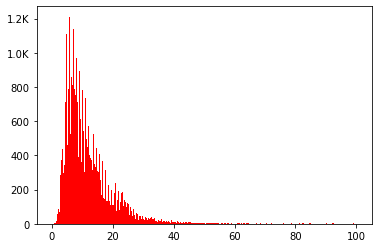

In [226]:
# Analisando histograma de P1 para decidir em quantos classes dividir
from pyspark_dist_explore import hist
fig, ax = plt.subplots()
hist(ax, df.select('P1'), bins = 1000, color=['red'], range=(0, 100))

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        5.000e+00, 1.000e+00, 1.500e+01, 6.000e+00, 4.000e+00, 2.000e+01,
        5.000e+00, 3.800e+01, 1.900e+01, 4.200e+01, 8.000e+01, 7.900e+01,
        1.900e+02, 6.000e+01, 1.740e+02, 2.130e+02, 5.000e+02, 4.090e+02,
        2.280e+02, 5.660e+02, 6.250e+02, 1.210e+03, 9.010e+02, 4.400e+02,
        1.012e+03, 1.106e+03, 1.772e+03, 5.910e+02, 1.222e+03, 1.287e+03,
        1.344e+03, 2.120e+03, 6.900e+02, 1.407e+03, 2.236e+03, 7.300e+02,
        2.323e+03, 7.630e+02, 1.586e+03, 2.395e+03, 8.370e+02, 2.435e+03,
        7.830e+02, 1.632e+03, 2.433e+03, 8.190e+02, 2.278e+03, 7.630e+02,
        1.569e+03, 2.205e+03, 6.910e+02, 2.135e+03, 7.230e+02, 1.331e+03,
        1.860e+03, 6.250e+02, 1.769e+03, 6.150e+02, 1.155e+03, 1.729e+03,
        5.920e+02, 1.133e+03, 1.073e+03, 1.101e+03, 1.594e+03, 5.140e+02,
        9.550e+02, 9.610e+02, 9.140e+02, 1.405e+03, 4.260e+02, 8.220e+02,
        8.330e+02, 7.480e+02, 1.098e+0

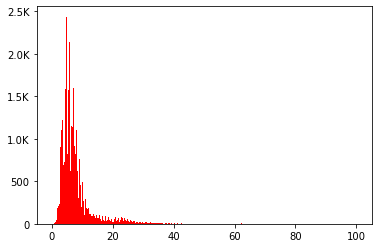

In [227]:
# Analisando histograma de P2 para decidir em quantos classes dividir
fig, ax = plt.subplots()
hist(ax, df.select('P2'), bins = 1000, color=['red'], range=(0, 100))

In [228]:
# Definindo classes de P1

P1Classes = [
    PClass("low <= 10", -1, 10),
    PClass("low <= 20", 10, 20),
    PClass("low <= 30", 20, 30),
    PClass("low <= 40", 30, 40),
    PClass("low <= 50", 40, 50),
    PClass("medium ", 50, 75),
    PClass("high", 75, 100),
    PClass("very high", 100),
]

def getP1Class(value):
    for P1Class in P1Classes:
        if value > P1Class.min and value <= P1Class.max:
            return P1Class.label

# Preenchendo as classes no dataframe
getBandUdf = udf(getP1Class, StringType())
dfWithP1Class = df.withColumn('P1Class', getBandUdf(df['P1']))

# Indexando
indexer = StringIndexer(inputCol="P1Class", outputCol="P1Indexed")
indexedP1Class = indexer.fit(dfWithP1Class).transform(dfWithP1Class)


# Testando
indexedP1Class.select('P1', 'P1Class', 'P1Indexed').show(20)

+-----+---------+---------+
|   P1|  P1Class|P1Indexed|
+-----+---------+---------+
|12.33|low <= 20|      1.0|
|11.17|low <= 20|      1.0|
|12.23|low <= 20|      1.0|
| 12.1|low <= 20|      1.0|
|  8.6|low <= 10|      0.0|
| 8.37|low <= 10|      0.0|
| 8.23|low <= 10|      0.0|
| 13.3|low <= 20|      1.0|
|  9.3|low <= 10|      0.0|
|  7.8|low <= 10|      0.0|
|14.37|low <= 20|      1.0|
|11.23|low <= 20|      1.0|
| 9.07|low <= 10|      0.0|
| 11.2|low <= 20|      1.0|
| 10.5|low <= 20|      1.0|
|10.17|low <= 20|      1.0|
| 13.2|low <= 20|      1.0|
|14.43|low <= 20|      1.0|
| 9.53|low <= 10|      0.0|
| 9.93|low <= 10|      0.0|
+-----+---------+---------+
only showing top 20 rows



In [229]:
indexedP1Class.select('P1', 'P1Class', 'P1Indexed').groupBy("P1Indexed").agg(f.count("*")).show(20)

+---------+--------+
|P1Indexed|count(1)|
+---------+--------+
|      0.0|   50582|
|      7.0|     148|
|      1.0|   32300|
|      4.0|     706|
|      3.0|    2157|
|      2.0|    9508|
|      6.0|     338|
|      5.0|     345|
+---------+--------+



In [230]:
# Definindo classes de P2

P2Classes = [
    PClass("low <= 10", -1, 10),
    PClass("low <= 20", 10, 20),
    PClass("low <= 30", 20, 30),
    PClass("medium ", 30, 54),
    PClass("high", 54, 70),
    PClass("very high", 70),
]

def getP2Class(value):
    for P2Class in P2Classes:
        if value > P2Class.min and value <= P2Class.max:
            return P2Class.label

# Preenchendo as classes no dataframe
getBandUdf = udf(getP2Class, StringType())
dfWithP2Class = df.withColumn('P2Class', getBandUdf(df['P2']))

# Indexando
indexer = StringIndexer(inputCol="P2Class", outputCol="P2Indexed")
indexedP2Class = indexer.fit(dfWithP2Class).transform(dfWithP2Class)

In [231]:
indexedP2Class.select('P2', 'P2Class', 'P2Indexed').groupBy("P2Indexed").agg(f.count("*")).show(20)

+---------+--------+
|P2Indexed|count(1)|
+---------+--------+
|      0.0|   80466|
|      1.0|   10365|
|      4.0|     398|
|      3.0|    1066|
|      2.0|    3665|
|      5.0|     124|
+---------+--------+



In [232]:
def performClassification(df, inputCols, originalCol, labelCol, featuresCol):
  # Criando a coluna de features
  assembler = VectorAssembler(inputCols=inputCols, outputCol=featuresCol)
  transformedDf = assembler.transform(df)

  # Definindo amostra de treino e de teste
  [train, test] = transformedDf.randomSplit([0.8, 0.2])
  
  # Criando classificador
  classifier = RandomForestClassifier(labelCol=labelCol, featuresCol=featuresCol)
  # classifier = MultilayerPerceptronClassifier(labelCol=labelCol, layers=[len(featuresCol)+1, 8, 8])
  # # classifier = LinearRegression(labelCol=target, featuresCol="features")
  # # classifier = NaiveBayes(labelCol=target, featuresCol="features")
  # # classifier = DecisionTreeRegressor(labelCol=target, featuresCol="features")
  # # classifier =  RandomForestRegressor(labelCol=target, featuresCol="features")
  # # classifier = GeneralizedLinearRegression(labelCol=target,featuresCol="features")
  
  # Criando pipeline
  pipeline = Pipeline(stages=[classifier])

  # Treinando o modelo
  model = pipeline.fit(train)

  # Fazendo as predições
  predictions = model.transform(test)

  # Calculando a precisão ponderada
  evaluation = MulticlassClassificationEvaluator(labelCol=labelCol, predictionCol="prediction", metricName="weightedPrecision")
  weightedPrecision = evaluation.evaluate(predictions)
    
  # Calculando o recall ponderado
  evaluation = MulticlassClassificationEvaluator(labelCol=labelCol, predictionCol="prediction", metricName="weightedRecall")
  weightedRecall = evaluation.evaluate(predictions)

  # Mostrando resultados
  print(f"WeightedPrecision = {weightedPrecision}")
  print(f"WeightedRecall = {weightedRecall}")
  # predictions.select(originalCol, labelCol, "prediction").show()

In [233]:
# Machine learning pra P1
inputColsP1 = ['pressure', 'temperature', 'humidity', 'df1UnixTimestamp', 'df1Lat', 'df1Long']
performClassification(indexedP1Class, inputColsP1, "P1", "P1Indexed", "features")

WeightedPrecision = 0.6464466201201311
WeightedRecall = 0.6956927867151013


In [234]:
# Machine learning pra P2
inputColsP2 = ['pressure', 'temperature', 'humidity', 'df1UnixTimestamp', 'df1Lat', 'df1Long']
performClassification(indexedP2Class, inputColsP2, "P2", "P2Indexed", "features")

WeightedPrecision = 0.8695462505367565
WeightedRecall = 0.8862229102167182
